# 1. Import the required libraries

In [2]:
# Standard code libraries
import os
import matplotlib.pyplot as plt

# Custom code libraries from ReSurfEMG
from resurfemg.helper_functions.config import Config
from resurfemg.data_connector import file_discovery
from resurfemg.postprocessing import features as feat
from resurfemg.postprocessing import quality_assessment as qa
from resurfemg.pipelines import ipy_widgets
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_connector.data_classes import (
VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [3]:
# Identify all recordings available for the selected patient/measurement_date

# First find the patients
config = Config()

# Then find the files for the selected patients:
base_path = config.get_directory('test_data')
folder_levels = None

emg_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='emg_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)

folder_levels = ['date', 'measurement']
vent_files = file_discovery.find_files(
    base_path=base_path,
    file_name_regex='vent_data_synth_pocc',
    extension_regex='poly5',
    folder_levels=None)

In [4]:
# If you want to select another file:
# btn_list_emg = ipy_widgets.file_select(
#     emg_files,
#     folder_levels=['files'],
#     default_value_select=None,
#     default_idx_select=[0])
# btn_list_vent = ipy_widgets.file_select(
#     vent_files,
#     folder_levels=['files'],
#     default_value_select=None,
#     default_idx_select=[0])

In [5]:
# Load the EMG and ventilator data recordings from the selected folders.
emg_file_chosen = os.path.join(base_path, emg_files['files'].values[0])
vent_file_chosen = os.path.join(base_path, vent_files['files'].values[0])
# Alternatively:
# emg_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_emg])
# vent_file_chosen = os.path.join(base_path, *[btn.value for btn in btn_list_vent])

data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

Reading file  C:/Users/robwa/repos/work/ReSurfEMG/test_data\emg_data_synth_pocc.poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:/Users/robwa/repos/work/ReSurfEMG/test_data\vent_data_synth_pocc.poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [6]:
# Store the EMG data in a group of TimeSeries objects
emg_timeseries = EmgDataGroup(
    y_emg,
    fs=fs_emg,
    labels=['ECG', 'EMGdi'],
    units=2*['uV'])


# Data is stored in:
# fs        --> emg_timeseries.fs
# labels    --> emg_timeseries.labels
# units     --> emg_timeseries.units
# ECG       --> emg_timeseries.channels[0] = TimeSeries object
# EMGdi     --> emg_timeseries.channels[1: TimeSeries object
#   with:
#   emg_timeseries.channels[0].fs = fs
#   emg_timeseries.channels[0].y_raw = y_emg[0, :]
#   emg_timeseries.channels[0].t_data = time axis data for y_raw
#   emg_timeseries.channels[0].y_clean = None
#   emg_timeseries.channels[0].y_baseline = None
#   emg_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'ECG' is automatically detected.

Auto-detected ECG channel from labels.


In [7]:
# Store the ventilator data in a group of TimeSeries objects
vent_timeseries = VentilatorDataGroup(
    y_vent,
    fs=fs_vent,
    labels=['Paw', 'F', 'Vvent'],
    units=['cmH2O', 'L/s', 'L'])

# Data is stored in:
# fs        --> vent_timeseries.fs
# labels    --> vent_timeseries.labels
# units     --> vent_timeseries.units
# ECG       --> vent_timeseries.channels[0: TimeSeries object
# EMGdi     --> vent_timeseries.channels[1] = TimeSeries object
#   with:
#   vent_timeseries.channels[0].fs = fs
#   vent_timeseries.channels[0].y_raw = y_vent[0, :]
#   vent_timeseries.channels[0].t_data = time axis data for y_raw
#   vent_timeseries.channels[0].y_clean = None
#   vent_timeseries.channels[0].y_baseline = None
#   vent_timeseries.channels[0].y_baseline = None
#   etc.
# From the labels 'P_aw', 'F', and 'Vvent' are automatically detected.

Auto-detected Pvent channel from labels.
Auto-detected Flow channel from labels.
Auto-detected Volume channel from labels.


# 3. Pre-process the data

In [8]:
# Filter
emg_timeseries.filter()
# Which equals:
# emg_timeseries.filter(
#     signal_type='raw',
#     hp_cf=20.0,
#     lp_cf=500.0,    
#     channel_idxs=[0, 1],
# )
# Where:
# signal_type:      Filter the raw, just assigned, data
# hp_cf:            High-pass cut-off frequency of 20 Hz
# lp_cf:            Low-pass cut-off frequency of 500 Hz
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean


In [9]:
# Gate the EMG
emg_timeseries.gating()
# Which equals:
# emg_timeseries.gating(
#     signal_type='clean',        
#     gate_width_samples=None,    
#     ecg_peak_idxs=None,         
#     ecg_raw=None,               
#     bp_filter=True,
#     channel_idxs=None,
# )
# Where:
# signal_type:          Filter the clean, just filtered, data
# gate_width_samples:   Gate width, `None` defaults to fs // 10
# ecg_peak_idxs:        Sample idxs of ECG peaks, when `None` peaks are 
#                       automatically identified.
# ecg_raw:              ECG data to detect ECG peaks in if no ecg_peak_idxs are
#                       provided. If `None` and no ecg-channel is detected
#                       from the labels the raw channel data is used.
# bp_filter:            True/False: Filter the provided ecg_raw between 1-500
#                       Hz before peak detection
# channel_idxs:         For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_clean


Auto-detected ECG channel from labels.


In [10]:
# Calculate the envelope of the signal
emg_timeseries.envelope()
# Which equals:
# emg_timeseries.envelope(
#     env_window=None,
#     env_type='rms',
#     signal_type='clean',
# )
# Where:
# env_window:           Envelope window width, `None` defaults to fs // 5
# env_type:             'rms' for root-mean-square (default), 'arv' for average
#                       rectified
# signal_type:          Calculate the envelope over the clean data

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_env

In [11]:
# Calculate the baseline for the EMG envelopes and p_vent
emg_timeseries.baseline()
# Which equals:
# emg_timeseries.baseline(
#     percentile=33,
#     window_s=int(7.5 * fs_emg),
#     step_s=fs_emg // 5,
#     method='default',
#     signal_type='env',
#     augm_percentile=25,
#     ma_window=None,
#     perc_window=None,
#     channel_idxs=[0, 1], 
# )
# Where:
# percentile:       Percentile of signal in the window to take as the baseline
#                   value 
# window_s:         Window length in samples (default: int(7.5 * fs))
# step_s:           Number of consecutive samples with the same baseline value
#                   (default: fs // 5)
# method:           'default' or 'slopesum'
# signal_type:      Calculate the baseline over the envelope (y_env) for emg 
#                   and over the original signal for p_vent
# augm_percentile   Augmented_percentile for slopesum baseline
# ma_window:        Moving average window in samples for average dy/dt in
#                   slopesum baseline
# perc_window:      'perc_window' for slopesum baseline.
# channel_idxs:     For all channels (None would default to this)

# --> Data is stored in:
# emg_timeseries.channels[channel_idx].y_baseline

vent_timeseries.baseline(
    channel_idxs=[0],
    signal_type='raw')

(370.0, 410.0)

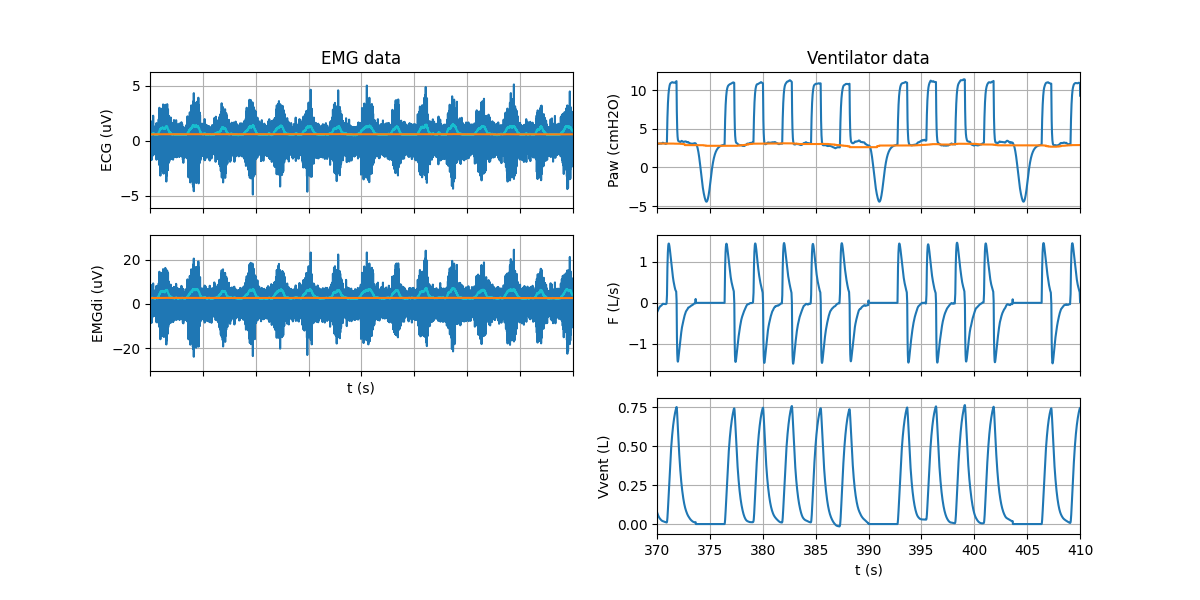

In [12]:
# Plot the raw data with the envelope
# EMG data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
emg_timeseries.plot_full(
    axes=axes_emg, signal_type='clean', baseline_bool=False)
# Which equals:
# emg_timeseries.plot_full(
#     axes=axes_emg,
#     channel_idxs=[0, 1],
#     signal_type='clean',
#     colors=['tab:cyan', 'tab:orange'],
#     baseline_bool=False
# )
# Where:
# axes:             Matplotlib axes object
# channel_idxs:     For all channels (None would default to this)
# signal_type:      Plot clean emg
# colors:           Plot the signal, and baseline in the respective colors
# baseline_bool:    Plot the baseline

emg_timeseries.plot_full(axes=axes_emg, signal_type='env', colors=colors)

axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

# Ventilator data data
axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

axes_vent[-1].set_xlim([370, 410])

# 3. Identify Pocc peaks of interest in p_vent

In [13]:
# Find occlusion pressures
vent_timeseries.peep
vent_timeseries.find_occluded_breaths(
    vent_timeseries.p_vent_idx, start_idx=360*vent_timeseries.fs)
# Which equals:
# vent_timeseries.find_occluded_breaths(
#     pressure_idx=vent_timeseries.p_vent_idx,
#     peep=vent_timeseries.peep,
#     start_idx=360*vent_timeseries.fs,
#     end_idx=len(y_vent)-1,
#     prominence_factor=0.8,
#     min_width_s=vent_timeseries.fs//10,
#     distance_s=vent_timeseries.fs//2,
# )
# Where:
# pressure_idx:         Channel idx of ventilator pressure signal (auto-detected)
# peep:                 Ventilator PEEP level (auto-detected)
# start_idx             Look for Pocc from sample idx
# end_idx:              Look for Pocc up to sample idx
# prominence_factor     Factor setting minimum prominence of Pocc peak
# min_width_s:          Mnimum Pocc peak width in samples
# distance_s:           Mnimum Pocc peak distance in samples

# --> Peak data is stored in:
# vent_timeseries.channels[vent_timeseries.p_vent_idx].peaks['Pocc']

In [14]:
# Detect on- and offsets of occlusion pressure peaks
p_vent = vent_timeseries.channels[vent_timeseries.p_vent_idx]
p_vent.peaks['Pocc'].detect_on_offset(baseline=p_vent.y_baseline)
# Which equals:
# p_vent.peaks['Pocc'].detect_on_offset(
#     baseline=p_vent.y_baseline,
#     method='default',   # == 'baseline_crossing'
#     fs=p_vent.fs,
#     slope_window_s=p_vent.fs // 5
# )
# Where:
# baseline:         Baseline for on-/offset detection.
# method:           On-/Offset detection method, 'default' == 'baseline_crossing'
# fs:               Signal fs
# slope_window_s:   For method 'slope_extrapolation', the window in samples
#                   where the slope is maximal

# The timings of the peaks is at:
print('The timings of the Pocc peaks is at:')
print(p_vent.peaks['Pocc'].peak_df['peak_idx']/p_vent.fs)

The timings of the Pocc peaks is at:
0    374.65
1    391.01
2    404.65
Name: peak_idx, dtype: float64


In [15]:
# Find supported breath pressures
v_vent = vent_timeseries.channels[vent_timeseries.v_vent_idx]
vent_timeseries.find_tidal_volume_peaks()
# Which equals:
# vent_timeseries.find_tidal_volume_peaks(
#     volume_idx=2,
#     start_idx=0,
#     end_idx=len(y_vent)-1,
#     width_s=v_vent.fs // 4,
#     threshold=0.25 * np.percentile(v_vent.y_raw, 90),
#     prominence=0.10 * np.percentile(v_vent.y_raw, 90),
#     threshold_new=0.5 * np.percentile(v_vent.y_raw[temp_peak_idxs], 90),
#     prominence_new=0.5 * np.percentile(v_vent.y_raw, 90),
#     pressure_idx=0,
# )
# Where:
# volume_idx:           Channel idx of ventilator volume signal (auto-detected)
# start_idx             Look for supported ventilator breath from sample idx
# end_idx:              Look for supported ventilator breath up to sample idx
# width_s:              Minimum supported ventilator breath width in samples
# threshold:            Minimum supported ventilator breath height in samples
# prominence:           Minimum supported ventilator breath prominence in samples
# threshold_new:        threshold, but filtering true breaths from originally identified peaks
# prominence_new:       prominence, but filtering true breaths from originally identified peaks
# pressure_idx:         Channel idx of ventilator pressure signal (auto-detected)

# --> Peak data is stored in:
# vent_timeseries.channels[vent_timeseries.p_vent_idx].peaks['ventilator_breaths']
# and
# vent_timeseries.channels[vent_timeseries.volume_idx].peaks['ventilator_breaths']

# 4. Identify all sEMG breaths, and find those closest to the Pocc peaks

In [16]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries.channels[1]
emg_di.detect_emg_breaths(peak_set_name='breaths')

# Similar to above for Pocc and ventilator breaths:
emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)
# --> Peak data is stored in:
# emg_di.peaks['breaths']

In [17]:
# Find the EMG peaks with the peak timing closest to the Pocc timings, and
# link ventilator Pocc peaks to EMG breaths
t_pocc_peaks_vent = p_vent.peaks['Pocc'].peak_df['peak_idx'].to_numpy() / p_vent.fs

emg_di.link_peak_set(
    peak_set_name='breaths',
    t_reference_peaks=t_pocc_peaks_vent,
    linked_peak_set_name='Pocc',
)
# Where:
# peak_set_name:          Peakset in current signal (emg_di) to find closest peaks in
# t_reference_peaks:      Timing of the peaks in the other (Pocc) signal
# linked_peak_set_name:   Name of linked peakset in current signal. Defaults to
#                         peak_set_name + '_linked'

# --> Peak data is stored in:
# emg_di.peaks['Pocc']

print('The timings of the Pocc peaks is in sEMGdi are at:')
print(emg_di.peaks['Pocc'].peak_df['start_idx']/emg_di.fs)


The timings of the Pocc peaks is in sEMGdi are at:
0    373.412598
1    389.713867
2    403.412598
Name: start_idx, dtype: float64


(np.float64(370.0), np.float64(410.0), np.float64(0.0), np.float64(1.0))

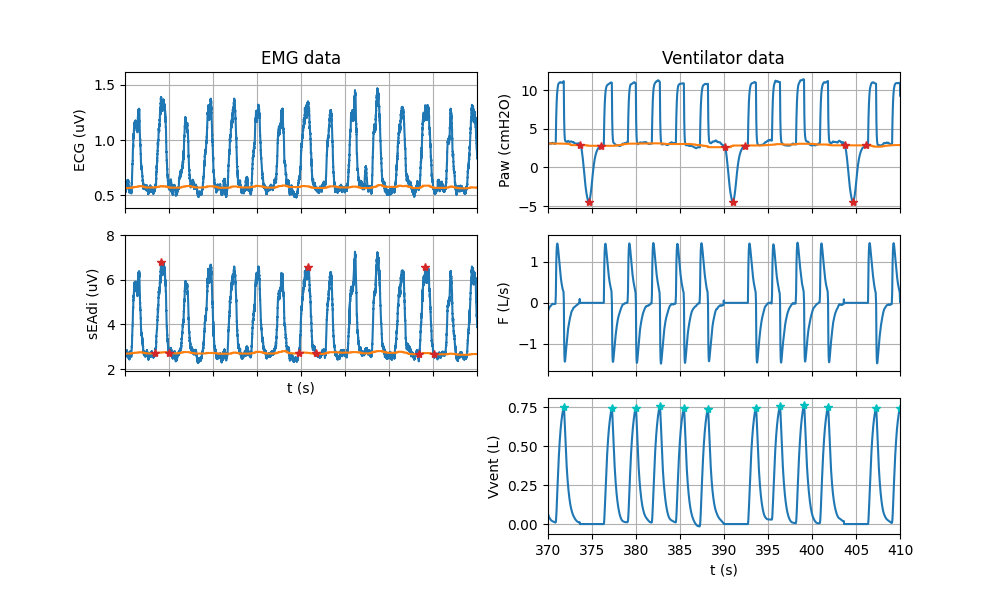

In [18]:
# Plot the identified Pocc peaks in p_vent and sEAdi
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:-1, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries.plot_full(axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='Pocc', axes=axes_emg[1])
# Which equals:
# emg_di.plot_markers(
#     peak_set_name='Pocc',
#     axes=axes_emg[1],
#     valid_only=False,
#     colors=['tab:red', 'tab:red', 'tab:red'],
#     markers=['*', '*', '*'],
# )
# Where:
# peak_set_name:    Peakset to plot the markers from
# axes:             Axes object to plot in
# valid_only:       Plot only valid peaks
# colors:           List of colours for the peak, start and end marker
# markers:          List of markers for the peak, start and end marker


axes_emg[1].set_ylabel('sEAdi (uV)')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
p_vent.plot_markers(peak_set_name='Pocc', axes=axes_vent[0])
v_vent.plot_markers(peak_set_name='ventilator_breaths',
                    axes=axes_vent[2], colors='c')

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([370, 410])

axis[-1, 0].axis('off')

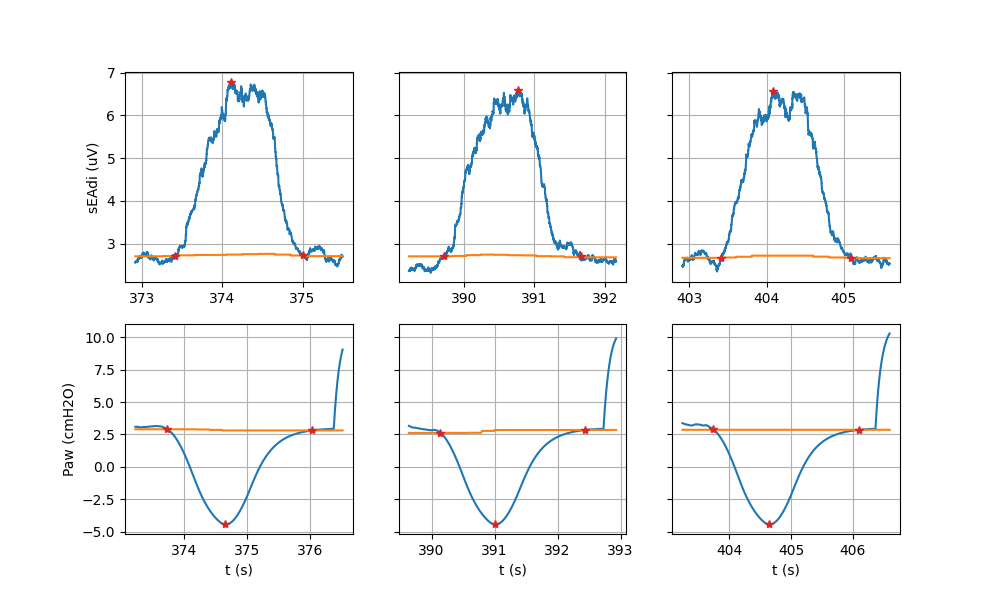

In [19]:
# Plot the individual peaks
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
# Which equals:
# emg_di.plot_peaks(
#     peak_set_name='Pocc',
#     axes=axes_emg,
#     signal_type=emg_di.peaks['Pocc'].signal,    # == 'env'
#     margin_s=emg_di.fs // 2,
#     valid_only=False,
#     colors=['tab:blue', 'tab:orange'],
#     baseline_bool=True
# )
# Where:
# peak_set_name:    Peakset to plot the markers from
# axes:             Axes object to plot in
# signal_type:      Plot the envelope data, from which the peaks are determined
# margin_s:         Plot margin_s samples before start_idx and after end_idx 
# valid_only:       Plot only valid peaks
# colors:           List of colours for the peak [0] and baseline [1]
# baseline_bool:    Plot the baseline
    
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

# 5. Calculate features

In [20]:
# Respiratory rates
tv_idxs = v_vent.peaks['ventilator_breaths'].peak_df['peak_idx'].to_numpy()
rr_vent, _ = feat.respiratory_rate(
    tv_idxs, fs_vent
)

emg_di_idxs = emg_di.peaks['breaths'].peak_df['peak_idx'].to_numpy()
rr_emg, _ = feat.respiratory_rate(
    emg_di_idxs, fs_emg
)

rr_vent, rr_emg

(21.978021978021978, 21.96639256346085)

In [23]:
# EMG amplitudes
emg_di_pocc_idxs = emg_di.peaks['Pocc'].peak_df['peak_idx'].to_numpy()
sEAdi_amplitudes = feat.amplitude(
    signal=emg_di.y_env,
    peak_idxs=emg_di_pocc_idxs,
    baseline=emg_di.y_baseline,
)
sEAdi_amplitudes

array([4.04940309, 3.86127861, 3.84515852])

In [20]:
# Calculate PTPocc
p_vent.calculate_time_products(
    peak_set_name='Pocc', 
    aub_reference_signal=p_vent.y_baseline,
    parameter_name='PTPocc')
# Which equals:
# p_vent.calculate_time_products(
#     peak_set_name='Pocc', 
#     include_aub=True,
#     aub_window_s=5 * p_vent.fs,
#     aub_reference_signal=p_vent.y_baseline,
#     parameter_name='PTPocc')
# )
# Where:
# peak_set_name:        Peakset to calculate the timeproduct over
# include_aub:          Include the area under the baseline in the time product
# aub_window_s:         Window length in samples in which the local extreme is sought.
# aub_reference_signal: Optional reference signal to find the local extreme 
#                       in, else the signal underlying the peakset is taken.
# parameter_name:       Name of the parameter in peakset.peak_df

# --> Parameter data is stored in:
# p_vent.peaks['Pocc'].peak_df[parameter_name]

print(p_vent.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [21]:
# Calculate ETPdi
emg_di.calculate_time_products(
    peak_set_name='Pocc', parameter_name='ETPdi')

print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi
0    766176     764749   768001   True  0.726961   2.279110  4.313010
1    800300     798134   802124   True  0.764316   2.321897  4.576422
2    827555     826189   829630   True  0.590109   2.345028  4.256199


# 6. Test Pocc and sEMG quality

In [22]:
# Test general signal characteristics
rr_vent, rr_emg
fraction_emg_breaths, _ = qa.evaluate_respiratory_rates(
    emg_breath_idxs=emg_di_idxs,
    t_emg=max(emg_di.t_data),
    rr_vent=rr_vent
)
print('The fraction detected EMG breaths is: {:0.2f} %'.format(
    100*fraction_emg_breaths))

The fraction detected EMG breaths is: 100.10 %


In [23]:
# Test Pocc quality
parameter_names = {
    'time_product': 'PTPocc'
}
p_vent.test_pocc_quality(
    peak_set_name='Pocc',
    parameter_names=parameter_names, 
    verbose=True)
# Which equals:
# p_vent.test_pocc_quality(
#     peak_set_name='Pocc',
#     cutoff={
#         'consecutive_poccs': 0,
#         'dP_up_10': 0.0,
#         'dP_up_90': 2.0,
#         'dP_up_90_norm': 0.8,
#     },
#     skip_tests=[],
#     parameter_names={
#         'time_product': 'PTPocc'
#     },
#     verbose=True
# )
# Where:
# peak_set_name:        Peakset to test
# cutoff:               The cut-off values for the tests
# skip_tests:           List of tests to skip. Any of: 'consecutive_poccs',
#                       'pocc_upslope'
# parameter_names:      Dictionary of renamed parameters. Required parameters
#                       are 'ventilator_breaths', and 'time_product', and need
#                       to be specified if renamed.
# verbose:              Print the output of the tests

# --> Peak quality data is stored in:
# p_vent.peaks['Pocc'].quality_values_df and
# p_vent.peaks['Pocc'].quality_outcomes_df

Test values:
   peak_idx  dP_up_10  dP_up_90  dP_up_90_norm
0     37465  0.009708  0.110633       0.039193
1     39101  0.008363  0.109885       0.039304
2     40465  0.007633  0.109652       0.039023
Test outcomes:
   peak_idx  baseline_detection  consecutive_poccs  pocc_upslope
0     37465                True               True          True
1     39101                True               True          True
2     40465                True               True          True


In [24]:
# The peak-validity is updated in the peak_df:
print(p_vent.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref    PTPocc
0     37465      37372    37602   True  0.629043   3.112269  7.967947
1     39101      39014    39244   True  0.612831   3.043785  7.816193
2     40465      40374    40611   True  0.503030   3.074270  7.895531


In [25]:
# Test EMG quality
parameter_names = {
    'time_product': 'ETPdi'
}
emg_di.test_emg_quality(
    peak_set_name='Pocc', parameter_names=parameter_names)
# Which equals:
# emg_di.test_emg_quality(
#     peak_set_name='Pocc',
#     cutoff={
#         'interpeak_distance': 1.1,
#         'snr': 1.4,
#         'aub': 40,
#         'curve_fit': 30,
#         'aub_window_s': 5*emg_di.fs
#     },
#     skip_tests=[],
#     parameter_names={
#         'time_product': 'ETPdi'
#     },
#     verbose=True
# )
# Where:
# peak_set_name:        Peakset to test
# cutoff:               The cut-off values for the tests
# skip_tests:           List of tests to skip. Any of: 'interpeak_dist',
#                       'snr', 'aub', 'curve_fit'
# parameter_names:      Dictionary of renamed parameters. Required parameters
#                       are ['interpeak_distance', 'snr', 'aub', 'curve_fit'],
#                       and need to be specified if renamed.
# verbose:              Print the output of the tests

# --> Peak quality data is stored in:
# emg_di.peaks['Pocc'].quality_values_df and
# emg_di.peaks['Pocc'].quality_outcomes_df

Test values:
   peak_idx       snr        aub  aub_y_refs       bell
0    766176  2.486289  16.855076    2.279110   9.672712
1    800300  2.432448  16.701173    2.321897  10.553799
2    827555  2.438140  13.864700    2.345028  10.320326
Test outcomes:
   peak_idx  baseline_detection  interpeak_distance   snr   aub  bell
0    766176                True                True  True  True  True
1    800300                True                True  True  True  True
2    827555                True                True  True  True  True


In [26]:
# The peak-validity is updated in the peak_df:
print(emg_di.peaks['Pocc'].peak_df)

   peak_idx  start_idx  end_idx  valid       AUB  aub_y_ref     ETPdi  \
0    766176     764749   768001   True  0.726961   2.279110  4.313010   
1    800300     798134   802124   True  0.764316   2.321897  4.576422   
2    827555     826189   829630   True  0.590109   2.345028  4.256199   

   bell_y_min    bell_a      bell_b    bell_c  
0    2.279110  4.579861  374.231900  0.561079  
1    2.321897  4.289192  390.593197  0.624578  
2    2.345028  4.316490  404.200751  0.588684  


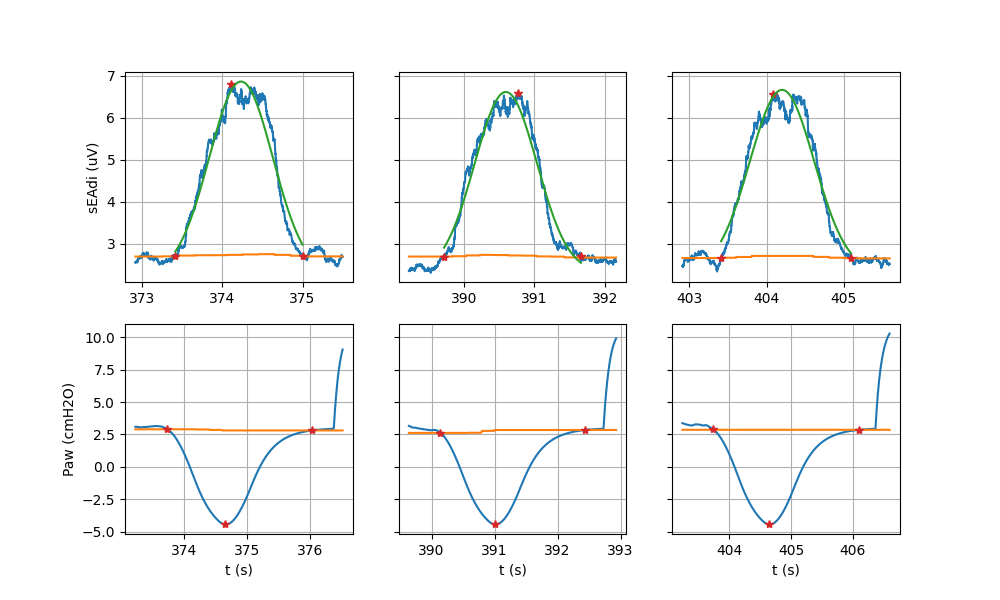

In [27]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_curve_fits(axes=axes_emg, peak_set_name='Pocc')
# Which equals:
# emg_di.plot_curve_fits(
#     peak_set_name='Pocc',
#     axes=axes_emg,
#     valid_only=False,
#     colors='tab:green'
# )
# Where:
# peak_set_name:    Peakset to plot the bell fit from
# axes:             Axes object to plot in
# valid_only:       Plot only valid peaks
# colors:           Colour for the bell-fit
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

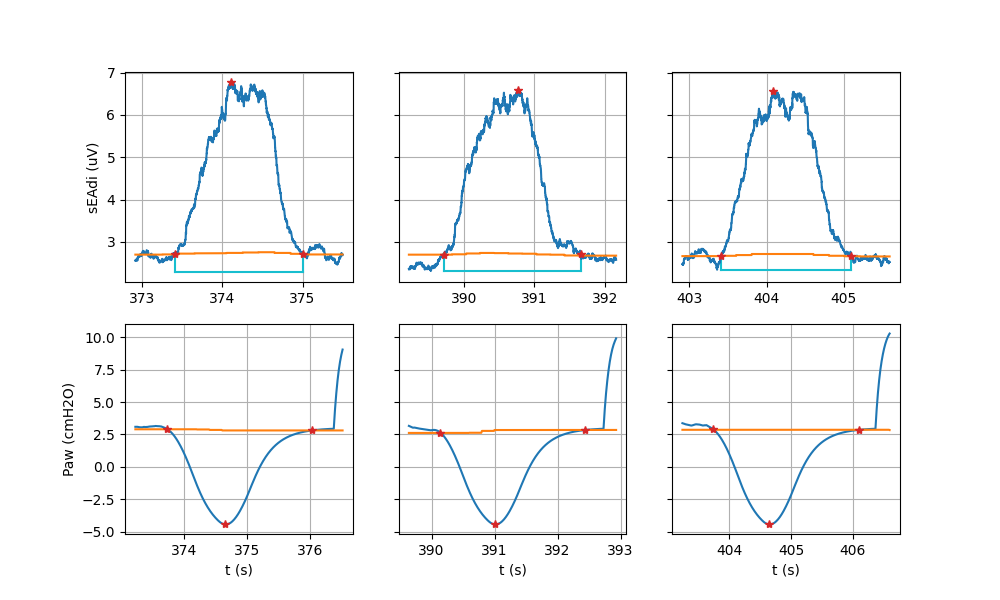

In [28]:
# Plot the individual peaks bell-fit
n_peaks = len(emg_di.peaks['Pocc'].peak_df['start_idx'].to_numpy())
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
emg_di.plot_aub(axes=axes_emg, signal_type='env', peak_set_name='Pocc')
# Which equals:
# emg_di.plot_curve_fits(
#     peak_set_name='Pocc',
#     axes=axes_emg,
#     valid_only=False,
#     colors='tab:cyan'
# )
# Where:
# peak_set_name:    Peakset to plot the aub from
# axes:             Axes object to plot in
# signal_type:      Plot aub for this data, in this case the aub data
# valid_only:       Plot only valid peaks
# colors:           Colour for the aub
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='Pocc')
emg_di.plot_markers(axes=axes_emg, peak_set_name='Pocc')
axes_emg[0].set_ylabel('sEAdi (uV)')

axes_vent = axis[1, :]
p_vent.plot_peaks(axes=axes_vent, peak_set_name='Pocc')
p_vent.plot_markers(axes=axes_vent, peak_set_name='Pocc')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

In [29]:
# Detect local high baselines in EMGdi
emg_di.calculate_time_products(
    peak_set_name='breaths', parameter_name='ETPdi')
emg_di.test_emg_quality(
    peak_set_name='breaths', parameter_names=parameter_names, verbose=False)


emg_di_aubs = emg_di.peaks['breaths'].peak_df['ETPdi'].to_numpy()
valid_aubs = qa.detect_local_high_aub(
    aubs=emg_di_aubs,
    threshold_percentile=75,
    threshold_factor=4,
)
valid_aubs

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [30]:
ETPdi_list = emg_di.peaks['breaths'].peak_df['ETPdi'].to_numpy()
valid_etps = qa.detect_extreme_time_products(
    ETPdi_list,
    upper_percentile=95.0,
    upper_factor=10.0,
    lower_percentile=5.0,
    lower_factor=.1,
)
valid_etps

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      